In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from preprocessing import load_if_in_country_or_lang
from preprocessing import categorize_views_for_df
from processing import filter_by_region_cat_code, build_regression_dataframe, load_preprocessed_events
from plot_regression import plot_regression_results_from_dict
import numpy as np
from regression import fit_nb_with_estimated_alpha, estimate_alpha, fit_nb, standardize_var, fit_nb_with_estimated_alpha_all_codes, standardize_var

In [72]:
df_crawled = pd.read_csv('events/new/processed_0_manually_with_wikiviews.csv').drop_duplicates()

In [73]:
df_crawled[df_crawled.cat == 'undefined'].head()

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,in_code_lang,in_code_region,date_month,views_baseline,view_country_article
200,Q107353229,Chinese elephants expedition,2020-03-01,Global South,China,Asia,undefined,"['Category:2021 in China', 'Category:Animal mi...",0,0.000000,...,China,2020.0,10228.970558,1.472280e+13,False,False,False,2020-03-01,1.842000e+06,20676.5
214,Q109110309,Wikipedia:Meetup/Johor 9,2019-05-01,Global South,Malaysia,Asia,undefined,"['Category:Wikipedia meetups in Malaysia', 'Ca...",0,0.000000,...,Malaysia,2019.0,11414.290367,3.646840e+11,False,False,False,2019-05-01,5.815000e+07,9350.0
245,Q138837,Catalan Republic (2017),2017-10-27,Global North,Spain,Europe,undefined,['Category:Redirects connected to a Wikidata i...,392630,0.000000,...,Spain,2017.0,28137.441564,1.312539e+12,True,False,False,2017-10-01,4.312950e+07,11320.0
247,Q1437630,"Solar eclipse of August 21, 2017",2017-08-21,Global North,United States,North America,undefined,"['Category:2017 in science', 'Category:2017 in...",1244878,157979.285714,...,United States,2017.0,59921.674703,1.947962e+13,True,True,True,2017-08-01,3.217767e+09,44815.0
1014,Q22081742,Wikipedia:Meetup/justfortherecord/Events/heroines,2016-01-15,Global North,Belgium,Europe,undefined,[],0,0.000000,...,Belgium,2016.0,41899.065629,4.757396e+11,True,False,False,2016-01-01,2.536950e+07,8722.0


In [77]:
df_crawled = df_crawled[df_crawled.cat != 'undefined']
df_crawled = df_crawled.drop_duplicates()
df_crawled[df_crawled.pagetitle.duplicated(keep=False)]

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,in_code_lang,in_code_region,date_month,views_baseline,view_country_article


In [78]:
df_crawled

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,in_code_lang,in_code_region,date_month,views_baseline,view_country_article
0,Q100021,Pakistan International Airlines Flight 661,2016-12-07,Global South,Pakistan,Asia,disaster,"['Category:2016 disasters in Pakistan', 'Categ...",248274,0.0,...,Pakistan,2016.0,1362.860008,2.775210e+11,False,True,False,2016-12-01,8.536700e+07,13789.0
1,Q100231328,Gretchen Whitmer kidnapping plot,2020-10-08,Global North,United States,North America,disaster,"['Category:2020 crimes in the United States', ...",74144,0.0,...,United States,2020.0,63122.594145,2.089375e+13,True,True,True,2020-10-01,3.151887e+09,48147.0
2,Q100256872,Killing of Babu Lal Vaishnav,2020-10-08,Global South,India,Asia,disaster,"['Category:2020 crimes in India', 'Category:20...",427,0.0,...,India,2020.0,1930.971218,2.664749e+12,False,True,False,2020-10-01,7.199060e+08,33666.0
3,Q100270220,Killing of Brendin Horner,2020-10-01,Global South,South Africa,Africa,disaster,"['Category:2020 deaths', 'Category:2020 in Sou...",0,0.0,...,South Africa,2020.0,5094.384038,3.021412e+11,False,True,False,2020-10-01,6.305050e+07,12988.0
4,Q100276857,2020 shooting of Los Angeles police officers,2020-09-12,Global North,United States,North America,disaster,"['Category:2020 in Los Angeles County, Califor...",0,0.0,...,United States,2020.0,63122.594145,2.089375e+13,True,True,True,2020-09-01,3.310591e+09,51047.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19650,Q99519567,Anexo:Ruta élite femenina en el Campeonato Mun...,2020-09-26,Global North,Italy,Europe,sports,['Categoría:Campeonato Mundial de Ciclismo en ...,385,0.0,...,Italy,2020.0,31238.048346,1.888709e+12,True,False,False,2020-09-01,8.955000e+05,3094.0
19652,Q99519600,Anexo:Ruta élite masculina en el Campeonato Mu...,2020-09-27,Global North,Italy,Europe,sports,['Categoría:Campeonato Mundial de Ciclismo en ...,1232,329.0,...,Italy,2020.0,31238.048346,1.888709e+12,True,False,False,2020-09-01,8.955000e+05,3094.0
19654,Q99622119,Accidente del Antonov An-26 en Chugúyev de 2020,2020-09-25,Global South,Ukraine,Europe,disaster,['Categoría:Accidentes e incidentes aéreos de ...,1268,0.0,...,Ukraine,2020.0,3557.477356,1.555819e+11,False,False,False,2020-09-01,1.945000e+05,1502.0
19655,Q99754052,Muerte de Joyce Echaquan,2020-09-28,Global North,Canada,North America,disaster,['Categoría:Joliette (Municipio regional de co...,0,0.0,...,Canada,2020.0,43559.710092,1.644037e+12,True,False,False,2020-09-01,1.706000e+06,3924.0


# Analyze views-after vs. views/before

TODO: build a regression which measures if an event gathers more than n views on Wikipedia

In [119]:
for code, df in df_crawled.groupby('code'):
    n_events_total = len(df)
    print(f'Analysing {code} ({n_events_total} Events)')

    for v in [0, 10, 100, 1000]: # [0.05, 1, 5, 10]:
        events_rel = df[(df.views_7_sum <= v)]
        #min_v = v * df.views_baseline / 1000000
        #events_rel = df[df.views_7_sum < min_v]
        n_events_rel = len(events_rel)
        print(f'\tLess than {v+1} views: {n_events_rel} ({n_events_rel/n_events_total*100:.2f}%)')

Analysing de (3375 Events)
	Less than 1 views: 1653 (48.98%)
	Less than 11 views: 1662 (49.24%)
	Less than 101 views: 1811 (53.66%)
	Less than 1001 views: 2568 (76.09%)
Analysing en (8184 Events)
	Less than 1 views: 1283 (15.68%)
	Less than 11 views: 1302 (15.91%)
	Less than 101 views: 1477 (18.05%)
	Less than 1001 views: 3067 (37.48%)
Analysing es (3628 Events)
	Less than 1 views: 770 (21.22%)
	Less than 11 views: 781 (21.53%)
	Less than 101 views: 1124 (30.98%)
	Less than 1001 views: 2256 (62.18%)
Analysing it (2793 Events)
	Less than 1 views: 1155 (41.35%)
	Less than 11 views: 1194 (42.75%)
	Less than 101 views: 1531 (54.82%)
	Less than 1001 views: 2176 (77.91%)


In [88]:
for code, df in df_crawled.groupby('code'):
    n_events_total = len(df)
    print(f'Analysing {code} ({n_events_total} Events)')

    for v in [0.01, 0.05, 0.1, 0.25, 0.5]:
        n_min_events = int(np.ceil(n_events_total*v))
        events_rel = df.nsmallest(n_min_events, 'views_7_sum')
        #min_v = v * df.views_baseline / 1000000
        #events_rel = df[df.views_7_sum < min_v]
        n_events_rel = len(events_rel)
        print(f'\tSmallest {n_min_events} events (bottom {v*100}%): {n_events_rel} ({n_events_rel/n_events_total*100:.2f}%)')
        print(f'\t\tViews by "largest of the smallest": {events_rel.tail(1).views_7_sum.values[0]}')

Analysing de (3375 Events)
	Smallest 34 events (bottom 1.0%): 34 (1.01%)
		Views by "largest of the smallest": 0
	Smallest 169 events (bottom 5.0%): 169 (5.01%)
		Views by "largest of the smallest": 0
	Smallest 338 events (bottom 10.0%): 338 (10.01%)
		Views by "largest of the smallest": 0
	Smallest 844 events (bottom 25.0%): 844 (25.01%)
		Views by "largest of the smallest": 0
	Smallest 1688 events (bottom 50.0%): 1688 (50.01%)
		Views by "largest of the smallest": 31
Analysing en (8184 Events)
	Smallest 82 events (bottom 1.0%): 82 (1.00%)
		Views by "largest of the smallest": 0
	Smallest 410 events (bottom 5.0%): 410 (5.01%)
		Views by "largest of the smallest": 0
	Smallest 819 events (bottom 10.0%): 819 (10.01%)
		Views by "largest of the smallest": 0
	Smallest 2046 events (bottom 25.0%): 2046 (25.00%)
		Views by "largest of the smallest": 334
	Smallest 4092 events (bottom 50.0%): 4092 (50.00%)
		Views by "largest of the smallest": 2853
Analysing es (3628 Events)
	Smallest 37 events

In [96]:
df_crawled['noticed'] = df_crawled.views_7_sum > 10

### Investigation of "noticed" events

In [99]:
from plot_regression import plot_cat_by_cat, plot_cat_by_cat_variable

In [124]:
f'{sum(df_crawled.noticed) / len(df_crawled)*100:.2f}% of OVERALL articles have >10 views'

'72.53% of OVERALL articles have >10 views'

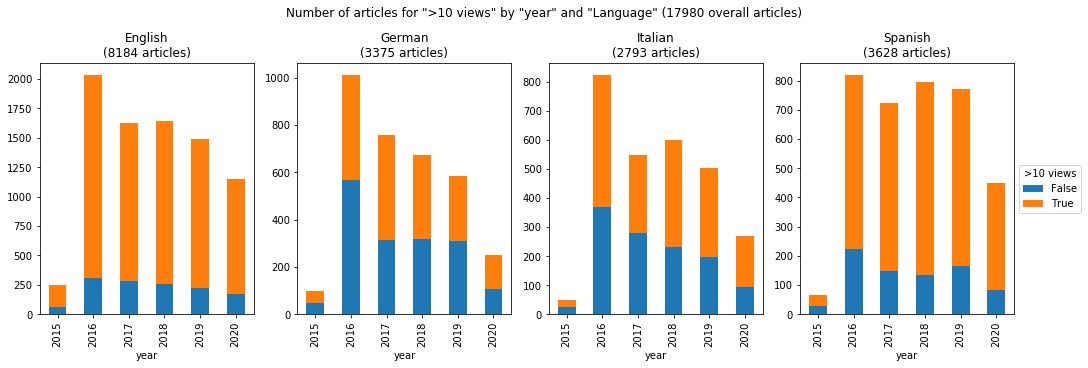

In [128]:
plot_cat_by_cat_variable(df_crawled, col_plot='code', col_x = 'year', col_bar='noticed', stacked=True, sharey=False, figsize=(15, 5))

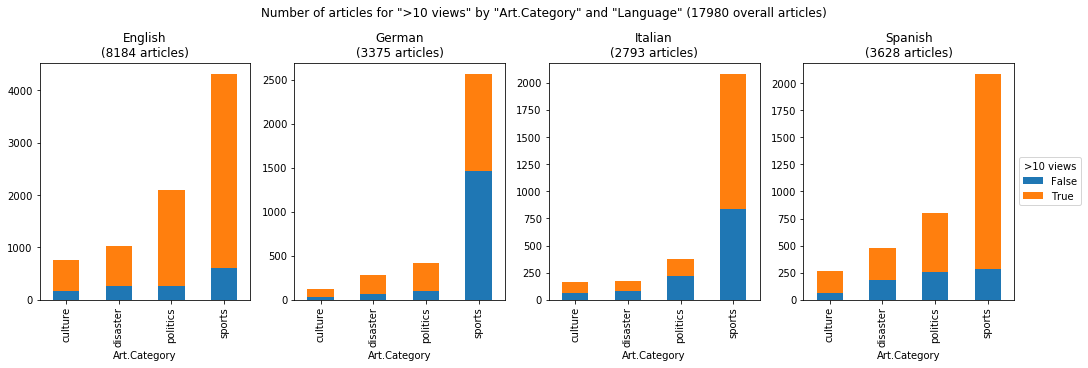

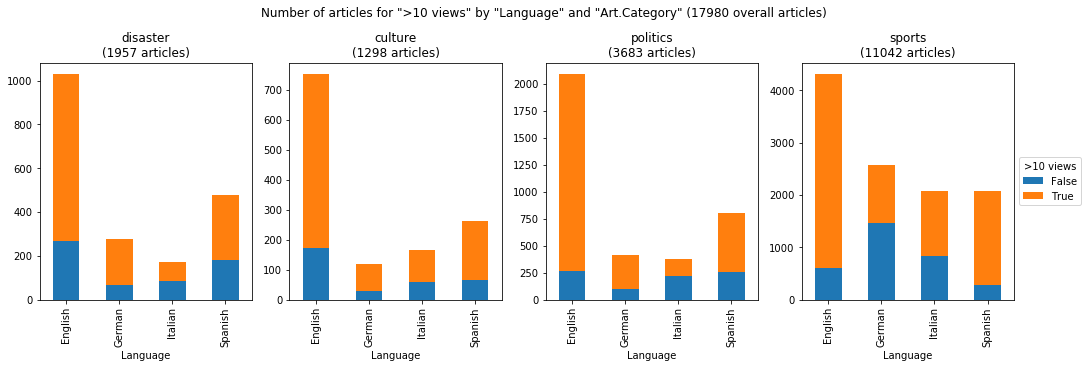

In [127]:
plot_cat_by_cat_variable(df_crawled, col_plot='code', col_x = 'cat', col_bar='noticed', stacked=True, sharey=False, figsize=(15, 5))
plot_cat_by_cat_variable(df_crawled, col_plot='cat', col_x = 'code', col_bar='noticed', stacked=True, sharey=False, figsize=(15, 5))

# Regression

In [297]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plot_regression import BASELINE_DICT, CAT_DICT, LABEL_RENAME_DICT, LABEL_SORT_DICT
from regression import transform_vars_for_regression, fit_logit_and_rename_coeffs, fit_regression_and_rename_coeffs_by_cat, nagelkerke, mcfadden, likelihood_ratio_test

df_reg = df_crawled[df_crawled.year > 2015]
df_reg = transform_vars_for_regression(df_reg.copy())
df_reg['noticed_int'] = df_reg.noticed.astype(int)
df_reg.describe()

,views_7_sum,views_before_mean,views_before_sum,views_before_max,views_before_min,views_before_median,views_before_increase,diff_days,year,edits_7_sum,...,views_baseline_z,view_country_article_z,bing_hits_z,view_country_article_log,views_baseline_log,bing_hits_log,GDP_pc_log,GDP_log,population_log,noticed_int
count,1.752400e+04,17524.000000,1.752400e+04,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000,...,1.752400e+04,1.752400e+04,1.752400e+04,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000
mean,1.879354e+04,505.729635,3.478577e+03,945.726432,297.645743,432.918569,487.016149,-19.412406,2017.689226,26.435974,...,2.919372e-17,-6.487494e-18,9.731240e-18,8.685505,16.197235,6.212895,9.939394,27.755795,17.815382,0.727517
std,1.221306e+05,3626.362287,2.535814e+04,6945.623872,2399.728356,3069.400341,4268.468788,507.707605,1.362913,100.797535,...,1.000000e+00,1.000000e+00,1.000000e+00,1.292987,3.472149,4.145783,1.151321,2.076593,1.717646,0.445250
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-35168.000000,-5990.000000,2016.000000,0.000000,...,-4.186023e-01,-8.470508e-01,-2.406814e-01,0.000000,0.000000,0.000000,4.676027,17.665728,9.256747,0.000000
25%,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-79.000000,2016.000000,0.000000,...,-4.178164e-01,-6.722900e-01,-2.406252e-01,7.802822,13.570889,2.756454,9.076299,26.605787,16.731682,0.000000
50%,6.005000e+02,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-3.000000,2018.000000,2.000000,...,-4.039807e-01,-3.838794e-01,-2.403270e-01,8.777247,16.494303,4.543295,10.409898,28.131505,18.006057,1.000000
75%,5.581500e+03,105.571429,5.840000e+02,195.000000,48.000000,83.000000,79.000000,6.000000,2019.000000,17.000000,...,-3.051591e-01,1.025077e-01,-1.557060e-01,9.495068,18.543106,10.012387,10.818299,28.696005,19.144178,1.000000
max,7.847440e+06,188749.000000,1.321243e+06,443489.000000,134559.000000,150619.000000,316295.000000,2143.000000,2020.000000,3887.000000,...,3.050404e+00,3.154267e+00,2.997703e+01,10.933393,21.963427,15.886164,12.152185,30.693130,21.067514,1.000000


#### Possible Features:
- Article features
    - category (categorical)
    - views 7d before the event
    - views 7d after the event
    - edits
- Wikipedia features
    - Event country has the article's Wikipeida version's language as an "official language" (bool)
    - Median daily pagviews from the event country to the language edition in the last 5 months
    - Median pageviews to the main article of the event country in the language edition in the last 5 months
    - Whether the Wikipedia language version spans multiple regions (bool)
- Geographical features
    - country (categorical)
    - continent (categorical)
    - geographic region via the world bank (categorical)
- Economical features
    - GDP
    - GDP per capita
    - oecd member (bool)
    - Country income class via the world bank (categorical)
- Media features:
    - Bing news hits when using article pagetitle as the search query in early 2022

In [289]:
logreg_0 = fit_logit_and_rename_coeffs(df_reg, 'noticed_int ~ C(code, Treatment(reference="en")) * C(cat, Treatment(reference="sports"))')
logreg_0.summary2()

PseudoR² - Nagelkerke: 0.178 | Mcfadden: 0.112


<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
===========================================================================
Model:                  GLM                 AIC:               18257.6731  
Link Function:          logit               BIC:               -152850.7138
Dependent Variable:     noticed_int         Log-Likelihood:    -9112.8     
Date:                   2022-04-28 12:41    LL-Null:           -10264.     
No. Observations:       17524               Deviance:          18226.      
Df Model:               15                  Pearson chi2:      1.75e+04    
Df Residuals:           17508               Scale:             1.0000      
Method:                 IRLS                                               
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                   1.8297   0.0447  40.9754 0.0000  1.7422  1.9172
code[T.de]                 -2.1190   0.0602 -35.1788 0.0000 -2.2371 -2.0009
code[T.es]                  0.0376   0.0786   0.4789 0.6320 -0.1164  0.1917
code[T.it]                 -1.4214   0.0634 -22.4273 0.0000 -1.5456 -1.2972
cat[T.culture]             -0.5502   0.1004  -5.4788 0.0000 -0.7470 -0.3534
cat[T.disaster]            -0.7606   0.0856  -8.8873 0.0000 -0.9284 -0.5929
cat[T.politics]             0.1213   0.0809   1.4998 0.1337 -0.0372  0.2799
code[T.de]:cat[T.culture]   2.0323   0.2449   8.2974 0.0000  1.5522  2.5123
code[T.es]:cat[T.culture]  -0.1713   0.1885  -0.9089 0.3634 -0.5407  0.1981
code[T.it]:cat[T.culture]   0.7693   0.2000   3.8465 0.0001  0.3773  1.1612
code[T.de]:cat[T.disaster]  2.2101   0.1726  12.8012 0.0000  1.8717  2.5485
code[T.es]:cat[T.disaster] -0.5856   0.1438  -4.0734 0.0000 -0.8674 -0.3038
code[T.it]:cat[T.disaster]  0.3400   0.1841   1.8472 0.0647 -0.0208  0.7008
code[T.de]:cat[T.politics]  1.3450   0.1486   9.0484 0.0000  1.0537  1.6363
code[T.es]:cat[T.politics] -1.1773   0.1295  -9.0909 0.0000 -1.4311 -0.9235
code[T.it]:cat[T.politics] -0.8237   0.1408  -5.8502 0.0000 -1.0997 -0.5478
===========================================================================

"""

In [301]:
logreg_1 = fit_logit_and_rename_coeffs(
    df_reg, 
    'noticed_int ~ C(code, Treatment(reference="en")) * (C(cat, Treatment(reference="sports")) + C(gni_class, Treatment(reference="H")) + C(gni_region, Treatment(reference="North America")))')
logreg_1.summary2()

PatsyError: specified level 'H' not found

In [293]:
logreg_2 = fit_logit_and_rename_coeffs(
    df_reg, 
    'noticed_int ~ C(code, Treatment(reference="en")) * (C(cat, Treatment(reference="sports"))  * C(gni_class, Treatment(reference="H"))) + views_baseline_z')

logreg_2.summary2()

PseudoR² - Nagelkerke: 0.199 | Mcfadden: 0.126


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Generalized linear model
=====================================================================================================
Model:                          GLM                          AIC:                        18070.9864  
Link Function:                  logit                        BIC:                        -152672.1482
Dependent Variable:             noticed_int                  Log-Likelihood:             -8972.5     
Date:                           2022-04-28 12:44             LL-Null:                    -10264.     
No. Observations:               17524                        Deviance:                   17945.      
Df Model:                       62                           Pearson chi2:               1.75e+04    
Df Residuals:                   17461                        Scale:                      1.0000      
Method:                         IRLS                                                                 
-----------------------------------------------------------------------------------------------------
                                            Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
-----------------------------------------------------------------------------------------------------
Intercept                                    1.7333     0.0536  32.3325 0.0000      1.6283     1.8384
code[T.de]                                  -1.6670     0.0756 -22.0462 0.0000     -1.8152    -1.5188
code[T.es]                                   0.0531     0.0937   0.5667 0.5709     -0.1305     0.2366
code[T.it]                                  -1.3421     0.0783 -17.1421 0.0000     -1.4955    -1.1886
cat[T.culture]                              -0.3128     0.1222  -2.5591 0.0105     -0.5524    -0.0732
cat[T.disaster]                             -0.7234     0.1220  -5.9312 0.0000     -0.9625    -0.4844
cat[T.politics]                              0.1259     0.0968   1.3003 0.1935     -0.0639     0.3157
gni_class[T.L]                              -0.8583     0.6924  -1.2396 0.2151     -2.2154     0.4988
gni_class[T.LM]                             -0.4668     0.1601  -2.9162 0.0035     -0.7806    -0.1531
gni_class[T.UM]                              0.5658     0.1206   4.6905 0.0000      0.3294     0.8023
cat[T.culture]:gni_class[T.L]               -0.5346     1.0760  -0.4968 0.6193     -2.6435     1.5743
cat[T.disaster]:gni_class[T.L]               1.0759     0.7370   1.4599 0.1443     -0.3685     2.5203
cat[T.politics]:gni_class[T.L]               1.6658     0.9180   1.8146 0.0696     -0.1334     3.4651
cat[T.culture]:gni_class[T.LM]              -0.1829     0.2997  -0.6103 0.5416     -0.7703     0.4045
cat[T.disaster]:gni_class[T.LM]              0.6439     0.2533   2.5414 0.0110      0.1473     1.1404
cat[T.politics]:gni_class[T.LM]              0.6367     0.2750   2.3154 0.0206      0.0977     1.1757
cat[T.culture]:gni_class[T.UM]              -1.2888     0.2988  -4.3137 0.0000     -1.8744    -0.7032
cat[T.disaster]:gni_class[T.UM]             -0.6436     0.2187  -2.9423 0.0033     -1.0723    -0.2149
cat[T.politics]:gni_class[T.UM]             -0.5295     0.2279  -2.3230 0.0202     -0.9763    -0.0827
code[T.de]:cat[T.culture]                    1.4455     0.2601   5.5578 0.0000      0.9357     1.9553
code[T.es]:cat[T.culture]                   -0.2692     0.2225  -1.2102 0.2262     -0.7052     0.1668
code[T.it]:cat[T.culture]                    0.6092     0.2181   2.7933 0.0052      0.1817     1.0366
code[T.de]:cat[T.disaster]                   1.6882     0.2328   7.2502 0.0000      1.2318     2.1445
code[T.es]:cat[T.disaster]                  -0.5978     0.2052  -2.9141 0.0036     -0.9999    -0.1957
code[T.it]:cat[T.disaster]                   0.3578     0.2709   1.3209 0.1865     -0.1731     0.8886
code[T.de]:cat[T.politics]                   1.3574     0.2021   6.7151 0.0000      0.9612     1.7536
code[T.

In [192]:
logit0_dict = fit_regression_and_rename_coeffs_by_cat(df_reg, 
                                                      'noticed_int ~ C(cat, Treatment(reference="sports")) * C(gni_class, Treatment(reference="H")) + views_baseline_z',
                                                      type='logit', show_summary=True, max_iter=100)

--------------- Summary for en ---------------
                       Results: Generalized linear model
Model:                   GLM                   AIC:                 6753.1159  
Link Function:           logit                 BIC:                 -64406.8432
Dependent Variable:      noticed_int           Log-Likelihood:      -3359.6    
Date:                    2022-04-28 09:04      LL-Null:             -3444.8    
No. Observations:        7938                  Deviance:            6719.1     
Df Model:                16                    Pearson chi2:        7.93e+03   
Df Residuals:            7921                  Scale:               1.0000     
Method:                  IRLS                                                  
-------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z|   [0.05   0.95] 
-------------------------------------------------------------------------------
Intercept       

In [ ]:
logreg_0 = smf.logit('noticed ~ code + cat + gni_class + gni_region + GDP_pc_log', data=df_reg)